<table>
<tr style="background-color:#FFFFFF;">
<td width=20%>
    <table>
        <tr><img style="text-align:left" src="./img/logo_uga.jpeg" width="80" ></br></a>
        </tr> 
    </table>
</td>
<td><center><h1>Lab 8 : Safe Machine Learning via Superquantile Optimization</h1></center></td>
<td width=15%>
    <table>
        <tr><img src="./img/logo_uw.png" width="300"></br></a>
        </tr>
    </table>
</td>
</tr>
<tr>
<td style="text-align:left">
    <table>
            <tr><a href="https://yassine-laguel.github.io" style="font-size: 15px ">Yassine Laguel <br></a></tr>
    </table>       
<td style="text-align:center">DATA 558, Spring 2021</td>
<td style="text-align:right">
    <table>
    <tr> <a href="https://ronakdm.github.io" style="font-size: 15px">Ronak Mehta<br></a> </tr>
    <tr> <a href="https://sites.stat.washington.edu/people/alecgt/" style="font-size: 15px">Alec Greaves-Tunnell <br></a> </tr>
    <tr> <a href="https://krishnap25.github.io" style="font-size: 15px">Krishna Pillutla </br></a> </tr>
    </table>
    </td> 
</tr>
</table>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## Overview

In this lab, we will:
- Discuss metrics to quantify robustness for both classification and regression.
- Investigate these metrics on two toy problems.
- Learn how to train superquantile-based models for classification and regression.
- Quantify and visualize the impact of these models on robustness.
- Apply these tools to real datasets. 


## 1. Motivations

Distributional robustness can be measured in two ways:

- Better performance for worst-case outcomes.
- Better performances for pessimistic distributional shifts.

### 1.1 Illustration on a regression task

Let us consider a linear regression task on the following synthetic training dataset:

$$
    y_i = \alpha x_i  + \beta + \varepsilon_i \quad \text{ with } \varepsilon_i = \beta\; \varepsilon_{1} + (1-\beta) \varepsilon_{
    2}
$$

where 
- $x_i \in \mathbb{R}$ is sampled from a uniform distribution on $[0,100]$.
- $\varepsilon_{1}$ and $\varepsilon_{2}$ follow a normal law with respective parameters $(\mu_1, \sigma_1) = (0, 1)$ and $(\mu_2, \sigma_2) = (10, 3)$.
- $\beta$ follows a Bernouilli distribution with parameter $p=0.8$.
- $\alpha = 0.2,\; \beta=1.$

Let's visualize our dataset together with performance of a classical linear model

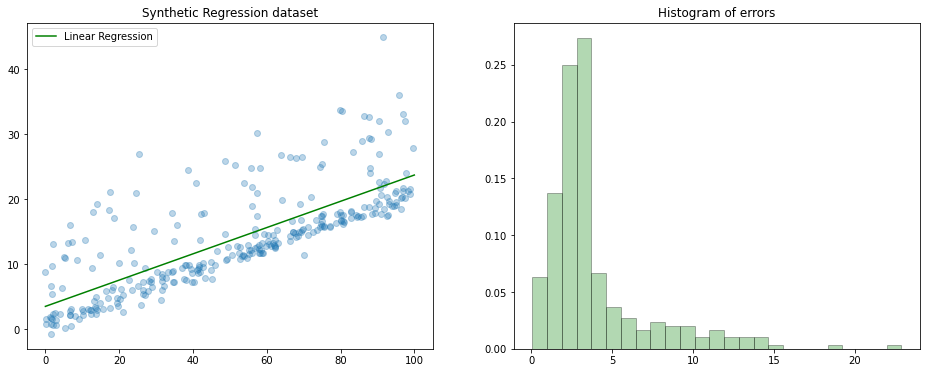

In [2]:
def generate_regression_data(seed=1, size=300):
    
    np.random.seed(seed)
    beta = 1.0
    alpha = 0.2
    x = np.random.uniform(high=100,size=size)
    eps1 = np.random.normal(loc=0.0, scale=1.0, size=size)
    eps2 = np.random.normal(loc=10.0, scale=5.0, size=size)
    beta = np.random.binomial(1, 0.7, size=size)
    
    noise = beta * eps1 + (1-beta) * eps2 
    y = beta * np.ones(size) + alpha * x + noise
    
    return x, y

def plot_synthetic_regression(x, y):
    
    formatted_x = x.reshape(-1, 1)
    lr = LinearRegression().fit(formatted_x, y)
    errors = np.abs(y - lr.predict(formatted_x))
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    graph = axes[0]
    graph.title.set_text('Synthetic Regression dataset')
    graph.scatter(x, y, alpha=0.3)
    t = np.array([0, 100]).reshape(-1,1)
    ft = lr.predict(t)
    graph.plot(t, ft, color='g', label='Linear Regression')
    graph.legend()
         
    hist = axes[1]
    hist.title.set_text('Histogram of errors')
    
#     kwargs = dict(histtype='bar', ec='black', alpha=0.3, bins=bins)
    weights = np.ones_like(errors)/len(errors)
    hist.hist(errors, weights=weights, color = "g", bins=25, alpha=0.3, histtype='bar', ec='black')

    plt.show()
    
x, y = generate_regression_data(seed=1)
plot_synthetic_regression(x, y)

**Exercise 1.1**: Comment the graphs. 

Let us compute a few metrics to evaluate the worst-case performances of our linear model.

**Exercise 1.2**: Implement the quantile and superquantile functions respectively defined as:

$$
\begin{align}
Q_p(U) &= \inf\{t \in \mathbb{R}, \mathbb{P}[U \leq t] \geq p\} \\
\text{and }\;\; \bar{Q}_p(U) &= \frac{1}{1-p} \int_{p'=p}^1 Q_{p'}(U) dp'
\end{align}
$$

In [4]:
from spqr.measures import quantile, superquantile

def quantile_function(p, U):
    v = np.sort(U)
    n = len(U)
    i = 0
    while i/n < p:
        i += 1
    return v[i]

def superquantile_function(p, U):
    ### <YOUR_CODE_HERE>
    superquantile = None
    ###
    
    v = np.sort(U)
    
    
    upper = ((quantile_function(p, U) - p) / (1-p)) * quantile_function(p, U)
    lower = ((1 - quantile_function(p, U)) / (1-p)) * 
    
    return superquantile

# Answers
##

def plot_synthetic_regression_with_metrics(x, y):
    
    formatted_x = x.reshape(-1, 1)
    lr = LinearRegression().fit(formatted_x, y)
    errors = np.abs(y - lr.predict(formatted_x))
    p=0.9
    q_p = quantile_function(p, errors)
    superq_p = superquantile_function(p, errors)
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    
    graph = axes[0]
    graph.title.set_text('Synthetic Regression dataset')
    graph.scatter(x, y, alpha=0.3)
    t = np.array([0, 100]).reshape(-1,1)
    ft = lr.predict(t)
    graph.plot(t, ft, color='g', label='Linear Regression')
    graph.legend()
         
    hist = axes[1]
    hist.title.set_text('Histogram of errors')
    weights = np.ones_like(errors)/len(errors)
    hist.hist(errors, weights=weights, color = "g", bins=25, alpha=0.3, histtype='bar', ec='black')
    hist.axvline(q_p, linestyle='-', color='g', label=str(p) + '-quantile')
    hist.axvline(superq_p, linestyle='-.', color='g', label=str(p) + '-superquantile')
    
    hist.legend()

    plt.show()

plot_synthetic_regression_with_metrics(x, y)

ModuleNotFoundError: No module named 'numba'

**Exercise 1.3**: Given the above distribution of errors, computes the following metrics and report them in a table:
- the minimum value 
- the mean value
- the $p$-quantile for $p\in \{0.0, 0.2, 0.5, 0.7, 0.9, 0.99\} $ 
- the $p$-superquantile for $p\in \{0.0, 0.2, 0.5, 0.7, 0.9, 0.99\}$ 

Comment the results. 

In [ ]:
### <YOUR_CODE_HERE>

**Your comments:**

### 1.2 Illustration on a classification task

Let us now consider a binary classification task on a real dataset: the Australian credit approcal [dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval) from the UCI Repository. 

In [ ]:
from course_utils import fetch_australian_dataset
x_tr, y_tr, x_te, y_te = fetch_australian_dataset(seed=1)

**Exercice 1.3:** Evaluate first the proportion of each class for both the training set and the testing set.

In [ ]:
### <YOUR_CODE_HERE>



A popular linear model to train for such tasks is the [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It consists in minizing the loss:

$$
        \min_{w, c} \frac{1}{n} \sum_{i=1}^{n} \log(\exp(-y_i(X_i^\top w + c)) + 1) + \frac{1}{nC} \|w\|_2^2
$$


Let us start by training a logistic regression model on the training sample and evaluate its performances on the training set and the testing set:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score

clf = LogisticRegression(fit_intercept=False).fit(x_tr, y_tr)

y_hat_tr = clf.predict(x_tr)
y_hat_te = clf.predict(x_te)

print("Train accuracy score : {acc:.3f}".format(acc=accuracy_score(y_tr, y_hat_tr)))
print("Train precision score : {acc:.3f}".format(acc=precision_score(y_tr, y_hat_tr)))

print("Test accuracy score : {acc:.3f}".format(acc=accuracy_score(y_te, y_hat_te)))
print("Test precision score : {acc:.3f}".format(acc=precision_score(y_te, y_hat_te)))

The model produced generalizes well on the observed testing set. We may now investigate performances of this model for a sequence of distributional shifts on the testing set. We implement a python function `shift` to rebalance arbitrarily the proportion of each class in the testing dataset.

In [ ]:
from course_utils import get_data_class
def shift(x, y, new_proportion, seed=1):
    generator = np.random.default_rng(seed)
    classes, counts = np.unique(y, return_counts=True)
    max_size = np.min(counts)
    
    x_0, y_0 = get_data_class(x, y, 0)
    x_1, y_1 = get_data_class(x, y, 1)
    subsampled_index_0 = generator.choice(np.arange(x_0.shape[0]), size=np.ceil(new_proportion * max_size).astype(np.int64),
                                          replace=False)
    subsampled_index_1 = generator.choice(np.arange(x_1.shape[0]), size=np.ceil((1.0-new_proportion) * max_size).astype(np.int64),
                                          replace=False)
    x_0 = x_0[subsampled_index_0]
    y_0 = y_0[subsampled_index_0]
    x_1 = x_1[subsampled_index_1]
    y_1 = y_1[subsampled_index_1]
    
    new_x = np.concatenate([x_0, x_1])
    new_y = np.concatenate([y_0, y_1])

    shuffled_index = generator.permutation(np.arange(new_x.shape[0]))
    new_x = new_x[shuffled_index]
    new_y = new_y[shuffled_index]

    return new_x, new_y

**Exercice 1.4:** Evaluate the performances of the linear model on several distributionnal shifts of the testing set. Comment.

In [ ]:
### <YOUR_CODE_HERE>

# Solution
# lst_prop = np.linspace(0,1, num=100)
lst_prop = np.linspace(0,1.0, num=100)

lst_accuracy = []
lst_min_accuracy = []
lst_max_accuracy = []

lst_precision = []
lst_min_precision = []
lst_max_precision = []

n_seeds = 30

for prop in lst_prop:
    temp_acc = []
    temp_prec = []
    
    for seed in range(n_seeds):
        shifted_x, shifted_y = shift(x_te, y_te, prop, seed=seed)
        y_hat = clf.predict(shifted_x)
        temp_acc.append(accuracy_score(shifted_y, y_hat))
        temp_prec.append(precision_score(shifted_y, y_hat))
    max_acc = np.mean(temp_acc) + np.std(temp_acc)
    min_acc = np.mean(temp_acc) - np.std(temp_acc)
    mean_acc = np.mean(temp_acc)
    max_prec = np.mean(temp_prec) + np.std(temp_prec)
    min_prec = np.mean(temp_prec) - np.std(temp_prec)
    mean_prec = np.mean(temp_prec)
    
    
    lst_accuracy.append(mean_acc)
    lst_min_accuracy.append(min_acc)
    lst_max_accuracy.append(max_acc)

    lst_precision.append(mean_prec)
    lst_min_precision.append(min_prec)
    lst_max_precision.append(max_prec)

fig, axes = plt.subplots(1, 2, figsize = (16, 6))

graph1 = axes[0]
graph1.title.set_text('Accuracies')
weights = np.ones_like(lst_accuracy)/len(lst_accuracy)
graph1.plot(lst_prop, lst_accuracy, color = "g", alpha=1.0)
graph1.fill_between(lst_prop, lst_min_accuracy, lst_max_accuracy, color = "g", alpha=0.3)
graph1.set_xlabel('shift proportion', fontsize=12)

graph2 = axes[1]
graph2.title.set_text('Precision')
weights = np.ones_like(lst_precision)/len(lst_precision)
graph2.plot(lst_prop, lst_precision, color = "g",  alpha=1.0)
graph2.fill_between(lst_prop, lst_min_precision, lst_max_precision, color = "g", alpha=0.3)
graph2.set_xlabel('shift proportion', fontsize=12)

plt.show()

## 2. The toolbox `spqr`

`sqpr` is a python toolbox, built on top of `sklearn` and aimed at providing optimization first order convex algorithms for the minimization of superquantile based measures. For more information we refer to its [online documentation](https://yassine-laguel.github.io/spqr/).

In this tutorial, we'll focus on how to use `SPQR` to perform distributionally robust regression and classification tasks. For that purpose, the toolbox provides users with two estimators:
- `DRLinearRegression`, for regression, which solves:

$$
\min_{w, c} \bar{Q}_p((Y - w_\top X - c)) + \frac{1.}{nC} \|w\|_2^2
$$

- `DRLogisticRegression` which solves:
$$
\min_{w, c} \bar{Q}_p(\log(\exp(-Y(X^\top w + c)) + 1)) + \frac{1.}{nC} \|w\|_2^2
$$

### 2.1 $\ell_2$-regression with `spqr`

Let's instantiate a `DRLinearRegression` object to fit our previous regression dataset. 

**Exercise 2.1:** Implement a distributionally robust linear regression on the previous regression dataset and compare its performance against the classical linear regression. 

In [ ]:
from spqr import DRLinearRegression

def plot_synthetic_regression_with_metrics(x, y):
    
    formatted_x = x.reshape(-1, 1)
    lr = LinearRegression().fit(formatted_x, y)
    errors = np.abs(y - lr.predict(formatted_x))
    p=0.9
    q_p = quantile_function(p, errors)
    superq_p = superquantile_function(p, errors)
    
    regressor = DRLinearRegression(p=0.9, fit_intercept=True)
    regressor.fit(formatted_x, y)
    errors2 = np.abs(y - regressor.predict(formatted_x).ravel())
    p=0.9
    q_p2 = quantile_function(p, errors2)
    superq_p2 = superquantile_function(p, errors2)

    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    
    graph = axes[0]
    graph.title.set_text('Synthetic Regression dataset')
    graph.scatter(x, y, alpha=0.3)
    t = np.array([0, 100]).reshape(-1,1)
    ft = lr.predict(t)
    ft2 = regressor.predict(t)
    graph.plot(t, ft, color='g', label='Linear Regression')
    graph.plot(t, ft2, color='r', label='Superquantile Linear Regression')
    graph.legend()
         
    hist = axes[1]
    hist.title.set_text('Histogram of errors')
    weights = np.ones_like(errors)/len(errors)
    weights2 = np.ones_like(errors2)/len(errors2)
    hist.hist(errors, weights=weights, color = "g", bins=25, alpha=0.3, histtype='bar', ec='black')
    hist.hist(errors2, weights=weights2, color = "r", bins=25, alpha=0.3, histtype='bar', ec='black')
    hist.axvline(q_p, linestyle='-', color='g', label=str(p) + '-quantile')
    hist.axvline(superq_p, linestyle='-.', color='g', label=str(p) + '-superquantile')
    hist.axvline(q_p2, linestyle='-', color='r', label=str(p) + '-quantile')
    hist.axvline(superq_p2, linestyle='-', color='r', label=str(p) + '-superquantile')
    
    hist.legend()
    
    plt.show()


In [ ]:
x, y = generate_regression_data(seed=1)
plot_synthetic_regression_with_metrics(x, y)

### 2.2 Logistic regression with `spqr`

In [ ]:
from spqr import DRLogisticRegression


super_clf = DRLogisticRegression(p=0.8, fit_intercept=False)
super_clf.fit(x_tr, y_tr)

y_hat_tr = super_clf.predict(x_tr)
y_hat_te = super_clf.predict(x_te)

print("Train accuracy score : {acc:.3f}".format(acc=accuracy_score(y_tr, y_hat_tr)))
print("Train precision score : {acc:.3f}".format(acc=precision_score(y_tr, y_hat_tr)))

print("Test accuracy score : {acc:.3f}".format(acc=accuracy_score(y_te, y_hat_te)))
print("Test precision score : {acc:.3f}".format(acc=precision_score(y_te, y_hat_te)))

**Exercise 2.1:** Compare the performances of the superquantile model with the risk-neutral model on a sequence of distributional shifts. Comment.

In [ ]:
lst_prop = np.linspace(0.0,1.0, num=100)

lst_accuracy = []
lst_min_accuracy = []
lst_max_accuracy = []

lst_precision = []
lst_min_precision = []
lst_max_precision = []

lst_accuracy2 = []
lst_min_accuracy2 = []
lst_max_accuracy2 = []

lst_precision2 = []
lst_min_precision2 = []
lst_max_precision2 = []

for prop in lst_prop:
    temp_acc = []
    temp_prec = []
    
    temp_acc2 = []
    temp_prec2 = []
    
    for seed in range(n_seeds):
        shifted_x, shifted_y = shift(x_te, y_te, prop, seed=seed)
        y_hat = clf.predict(shifted_x)
        y_hat2 = super_clf.predict(shifted_x)
        temp_acc.append(accuracy_score(shifted_y, y_hat))
        temp_prec.append(precision_score(shifted_y, y_hat))
        temp_acc2.append(accuracy_score(shifted_y, y_hat2))
        temp_prec2.append(precision_score(shifted_y, y_hat2))

    max_acc = np.mean(temp_acc) + np.std(temp_acc)
    min_acc = np.mean(temp_acc) - np.std(temp_acc)
    mean_acc = np.mean(temp_acc)
    max_prec = np.mean(temp_prec) + np.std(temp_prec)
    min_prec = np.mean(temp_prec) - np.std(temp_prec)
    mean_prec = np.mean(temp_prec)
    

    max_acc2 = np.mean(temp_acc2) + np.std(temp_acc2)
    min_acc2 = np.mean(temp_acc2) - np.std(temp_acc2)
    mean_acc2 = np.mean(temp_acc2)
    max_prec2 = np.mean(temp_prec2) + np.std(temp_prec2)
    min_prec2 = np.mean(temp_prec2) - np.std(temp_prec2)
    mean_prec2 = np.mean(temp_prec2)
    
    lst_accuracy.append(mean_acc)
    lst_min_accuracy.append(min_acc)
    lst_max_accuracy.append(max_acc)
    lst_precision.append(mean_prec)
    lst_min_precision.append(min_prec)
    lst_max_precision.append(max_prec)
    
    lst_accuracy2.append(mean_acc2)
    lst_min_accuracy2.append(min_acc2)
    lst_max_accuracy2.append(max_acc2)
    lst_precision2.append(mean_prec2)
    lst_min_precision2.append(min_prec2)
    lst_max_precision2.append(max_prec2)
    
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

graph1 = axes[0]
graph1.title.set_text('Accuracies')
graph1.plot(lst_prop, lst_accuracy, color = "g", alpha=1.0, label='Logistic Regression')
graph1.plot(lst_prop, lst_accuracy2, color = "r", alpha=1.0, label='Superquantile Logistic Regression')
graph1.fill_between(lst_prop, lst_min_accuracy, lst_max_accuracy, color = "g", alpha=0.3)
graph1.fill_between(lst_prop, lst_min_accuracy2, lst_max_accuracy2, color = "r", alpha=0.3)
graph1.set_xlabel('shift proportion', fontsize=12)
graph1.legend()

graph2 = axes[1]
graph2.title.set_text('Precision')
graph2.plot(lst_prop, lst_precision, color = "g",  alpha=1.0, label='Logistic Regression')
graph2.plot(lst_prop, lst_precision2, color = "r",  alpha=1.0, label='Superquantile Logistic Regression')
graph2.fill_between(lst_prop, lst_min_precision, lst_max_precision, color = "g", alpha=0.3)
graph2.fill_between(lst_prop, lst_min_precision2, lst_max_precision2, color = "r", alpha=0.3)
graph2.set_xlabel('shift proportion', fontsize=12)
graph2.legend()

plt.show()

## 3. The iWildCam Challenge Dataset

In this section, we will not introduce any new content, but rather work through the method on a much more realistic example than before

The [iWildCam](https://wilds.stanford.edu/datasets/#iwildcam) dataset contains images of various elements of nature, such as animals and landscapes. The original number of data points is ~130,000 training examples, ~10,000 validation examples, and ~40,000 test examples. There are a total of 182 training classes, not all of which are present in the validation and test sets. These are captured by camera traps in various wildlife habitats. There is drastic variation in illumination, camera angle, background, vegetation, color, and relative animal frequencies, which results in models generalizing poorly to new camera trap deployments.

**Exercise 3.1**: Print the sorted counts of the classes in the training set. What do you notice? (*Hint:* use `numpy.unique`.)

In [ ]:
import numpy as np

y_train_full = np.load("data/y_train.npy")

## <YOUR CODE HERE>
classes, counts = None
##

While the original dataset uses images, we have featurized the dataset into lower-dimensional real vectors. Additionally, we have subsampled the data significantly, such that that there are fewer classes, and more data per class. Observe the shapes of the reduced data matrices.

In [ ]:
X_train = np.load("data/X_train_reduced.npy")
y_train = np.load("data/y_train_reduced.npy")
X_val = np.load("data/X_val_reduced.npy")
y_val = np.load("data/y_val_reduced.npy")
X_test = np.load("data/X_test_reduced.npy")
y_test = np.load("data/y_test_reduced.npy")

print("X train shape:", X_train.shape)
print("X val shape:", X_val.shape)
print("X test shape:", X_test.shape)

classes, counts = np.unique(y_train, return_counts=True)
print(np.sort(counts))

While there this reduced dataset is easier to handle both statistically and computationally, there is significant class imbalance still. We will try downsampling the majority class.

**Exercise 3.2**: Downsample the majority class of `y_train` by a factor of 3.

In [ ]:
np.random.seed(123)

## <YOUR CODE HERE>
X_tr = None
y_tr = None
##

Here, we store a map from class to index, as not all classes are present in the validation and test set. We also show the performance of the "chance" classifier, that predicts the value of the largest class every time.

In [ ]:
class_to_idx = {}
for i, class_ in enumerate(classes):
    class_to_idx[class_] = i

classes, counts = np.unique(y_tr, return_counts=True)
print(counts)
print("Chance:", counts.max() / counts.sum())

Next, we get baseline performance using logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(123)

C_range = np.logspace(-5, 0, 5)

best_acc = -1
best_C = None
lr = None
try:
    for C in C_range:
        print("Evaluating C = %0.5f..." % C)
        model = LogisticRegression(C=C, solver='liblinear').fit(X_tr, y_tr)
        
        acc = accuracy_score(y_val, model.predict(X_val))
        print("\t Accuracy:", acc)
        if acc > best_acc:
            best_acc = acc
            best_C = C
            lr = model

    print("Best C:", best_C)
    print("Best accuracy:", best_acc)
except KeyboardInterrupt:
    print("Graceful Exit")

This is significantly better than chance! Now, we will compute a few metrics on the test set. Of interest to us is the performance of a classifier at the *tail of its loss*. We compute both the accuracy and $p$-th superquantile for various values of $p$ on the test set for the logistic regression trained earlier.

In [ ]:
from sklearn.metrics import precision_score, recall_score

def compute_metrics(y_proba, y_true, ps):
    
    # Test accuracy.
    y_pred = np.argmax(y_proba, axis=1)
    acc = accuracy_score(y_true, y_pred)

    # Log losses.
    n = len(y_true)
    losses = np.zeros(n)
    for i in range(n):
        losses[i] = -np.log(y_proba)[i, class_to_idx[y_true[i]]]

    # sq_loss = [sq(losses, p) for p in ps]
    sq_loss = [superquantile_function(p, losses) for p in ps]
    
    return acc, sq_loss

In [ ]:
ps = [0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

In [ ]:
lr_acc, lr_sq_loss = compute_metrics(lr.predict_proba(X_test), y_test, ps)

In [ ]:
from spqr import DRLogisticRegression

def softmax(Z):
    np.clip(Z, -10, 10)
    norm_constant = np.exp(Z).sum(axis=1).reshape(-1, 1)
    
    return np.exp(Z) / norm_constant

def predict_proba(model, x):
    """ Gives a prediction of x
            :param ``numpy.array`` x: input whose label is to predict
            :return:  value of the prediction
    """
    self = model
    formatted_x = np.ones((x.shape[0], self.n_features + self.fit_intercept))
    formatted_x[:, self.fit_intercept:] = x
    casted_sol = np.reshape(self.solution, (self.n_features + self.fit_intercept, self.n_classes))
    probas = softmax(np.dot(formatted_x, casted_sol))

    return probas

Next, we apply the the Distributionally Robust Logistic Regression (DRLR) method to the same data, with $p = 0.8$, and a hyperparameter search over $mu$ (an optimization parameter).

In [ ]:
mus = [0.1, 1, 10, 100, 1000]
lmbda = 1 / best_C
p = 0.8

best_mu = -1
best_acc = -1
try:
    for mu in mus:

        print("Evaluating mu = %f..." % mu)

        model = DRLogisticRegression(p=p, mu=mu, lmbda=lmbda)
        model.fit(X_tr, y_tr)

        acc = accuracy_score(y_val, model.predict(X_val))
        print("\t Accuracy:", acc)
        if acc > best_acc:
            best_acc = acc
            best_mu = mu
            drlr = model

    print("Best mu:", best_mu)
    print("Best accuracy:", best_acc)
except KeyboardInterrupt:
    print("Graceful Exit")

Note that the accuracy above is not a good as LR, but it is not what we are optimizing for. Instead, we will observe the tail of the losses, and ensure that the *largest ones are not too large*.

In [ ]:
drlr_acc, drlr_sq_loss = compute_metrics(predict_proba(drlr, X_test), y_test, ps)

Finally, plot the $p$-th superquantile of the losses on the test set, as a function of $p$.

In [ ]:
import matplotlib.pyplot as plt

print("LR Accuracy:", lr_acc)
print("DRLR Accuracy:", drlr_acc)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(ps, lr_sq_loss, color="red", linewidth=3, label="LR")
ax.set_label("p")
ax.plot(ps, drlr_sq_loss, color="blue", linewidth=3, label="DRLR")
ax.legend()
ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$p$-Superquantile Log-Loss (Test)")
ax.set_title("Classification Performance on the iWildCam Benchmark")

plt.show()

## 4. Clustering with k-means

Clustering, also known in signal processing as quantization, is an unsupervised learning method in which observations are associated with an element from a finite class. The elements of this class are considered _cluster labels_, and a _cluster_ consists of all observations with the same label. In this section, we will consider clustering the `Hawks` dataset, which contains physical measurements from three species of hawk. 

In [ ]:
from sklearn.cluster import KMeans, kmeans_plusplus

from matplotlib import cm

In [ ]:
# data
dat = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Hawks.csv')
hawks = dat[['Tail','Wing','Species']].dropna()

X = hawks[['Tail', 'Wing']]
f, g = pd.factorize(hawks['Species'])

In [ ]:
pd.plotting.scatter_matrix(X, c=f, marker='o', cmap='Set2', figsize=(6,6));

A clustering algorithm defines and optimizes a formal criterion for assigning observations to clusters. Here we will consider a classic algorithm: k-means clustering.

__k-means__

The k-means clustering method partitions observations in a dataset into $k$ clusters by minimizing the sum of within-group variances of each cluster. This criterion expresses the intuitive notion that clusters should represent groups of observations that are "close" to one another. Given a set of observations $\{x_1, ..., x_n\}$ with each $x_i \in \mathbb{R}^d$, the optimization problem is

$$
\text{min}_{\mu_1, ..., \mu_k} \sum_{i=1}^n \text{min}_{\mu \in C} ||x_i - \mu||_2^2
$$

That is, we search for $k$ cluster centers $\mu_1, ..., \mu_k$ such that the sum of squared distances from each observation to the nearest cluster center is minimized. The observation $x_i$ is assigned to the cluster $j \in \{1, ..., k\}$, where $j$ is the index of the cluster center $\mu_j$ minimizing the distance to $x_i$. In other words,

$$
x_i \in C_j \iff j = \text{argmin}_{j' \in \{1, ..., k\}} ||x_i - \mu_{j'}||_2^2,
$$

where $C_j$ denotes the set of observations in cluster $j$.

__Optimization__

The optimization problem can be phrased as a search over all assignments of $n$ observations to $k$ clusters. As such, it is combinatorial and non-convex in nature. We define a greedy algorithm that improves the clustering quality (i.e. decreases the objective) at every iteration, and which is guaranteed to converge at a local minimum:

- Initialize $k$ cluster centers $\mu_1, ..., \mu_k$

- While not converged:
    - Assign each observation $x_i$ to the cluster $j$ minimizing $||x_i - \mu_j||_2^2$
    - Re-compute each cluster center $\mu_j$ as the mean of the observations $x_i \in C_j$:
        
$$
\mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i
$$

K-means clustering is implemented in `sklearn` in the `sklearn.cluster` module. Below we introduce the API on a simple example:

In [ ]:
# kmeans in sklearn
kmeans = KMeans(n_clusters=3, init='random', 
                n_init=5, algorithm='full').fit(X)

In [ ]:
def kmeans_obj(X, centers, labels):
    return np.sum([np.linalg.norm(x-centers[labels[i]])**2 for i, x in enumerate(X)])

In [ ]:
# compute for kmeans output
centers = kmeans.cluster_centers_
labels = kmeans.labels_

kmeans_obj(X.values, centers, labels)

In [ ]:
kmeans.inertia_ # compare to sklearn value

In [ ]:
# show objective decrease over iterations
obj = [KMeans(n_clusters=3, init='random',
             n_init=1, algorithm='full',
             random_state=0, max_iter=t).fit(X).inertia_ for t in range(1,16)]

In [ ]:
plt.plot(obj)
plt.ylabel('Objective')
plt.xlabel('Iterations');

In [ ]:
# plot 
cmap = cm.get_cmap('Set2')
cols = [cmap(x) for x in labels]
X['labels'] = labels
X.plot.scatter('Wing', 'Tail', c=cols, cmap='Set2')
for c in centers:
    plt.plot(c[1], c[0], 'kX', markersize=8)
    
plt.show()

__The importance of initialization__

The non-convexity of the k-means problem implies that the result will depend on the initialization of the algorithm. This can be quite important in practice, with different initializations leading to different cluster assignments, which in turn may vary in their quality (in terms of the objective value) and interpretation. We will consider three approaches to initializing the clusters.

1. _Naive method: random initialization_

As a first idea, we could consider simply choosing the initial centers at random. While simple to implement, this method completely ignores the data and thus is not likely to work well except in simple and easy cases. 

A common solution to this problem is to run the entire algorithm multiple times from many random starting points (i.e. "re-starting"), and to select the final clustering with the lowest objective.


In [ ]:
def kmeans_randinit_trial(): # run a single trial with random init
    kmeans = KMeans(n_clusters=3, init='random', 
                    n_init=1, algorithm='full').fit(X)

    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    obj = kmeans_obj(X.values, centers, labels)
    cols = [cmap(x) for x in labels]
    X['labels'] = labels
    X.plot.scatter('Wing', 'Tail', c=cols, cmap='Set2')
    for c in centers:
        plt.plot(c[1], c[0], 'kX', markersize=8)
        
    plt.title('Final objective value: {:.3f}'.format(obj))
    plt.show()

In [ ]:
kmeans_randinit_trial()

2. _K-means++_

The initialization can often be dramatically improved by using the data to estimate a reasonable starting point. A well-known method for this is the `kmeans++` approach:

- Choose an observation uniformly at random from the data. Set this as the first initial center.

- While the number of centers chosen is less than k:
    - For each $x_j$ that is not a center, compute
    
    $$
    d_j = \text{min}_{c \in C^{(0)}} ||x_j - c||_2^2,
    $$
    where $C^{(0)}$ is the set of initial centers already chosen.
    
    - Select a new observation as an additional center by drawing randomly from the set $\{x_j : x_j \notin C^{(0)}$ with probability proportional to $d_j^2$.
- Return set of initial centers $C^{(0)}$.

This is implemented as an optional argument to the `KMeans` constructor, but we can also use the function `kmeans_plusplus` to directly compute and visualize the results of this initialization method.

In [ ]:
kpp_centers, kpp_ixs = kmeans_plusplus(X.values, n_clusters=3)
kmeans = KMeans(n_clusters=3, init=kpp_centers, n_init=1, algorithm='full').fit(X)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

X.plot.scatter('Wing', 'Tail', ax=axs[0])
for c in kpp_centers:
    axs[0].plot(c[1], c[0], 'rX', markersize=8)
axs[0].set_title('Kmeans++ initialization')    

cmap = cm.get_cmap('Set2')
cols = [cmap(x) for x in kmeans.labels_]
X.plot.scatter('Wing', 'Tail', ax=axs[1], c=cols)
for c in kmeans.cluster_centers_:
    axs[1].plot(c[1], c[0], 'kX', markersize=8)
axs[1].set_title('Final objective value: {:.3f}'.format(kmeans.inertia_));

3. _Iterative Voronoi centroids_

A third option, developed in the signal processing literature for quantization, iteratively constructs the initial cluster centers by the following algorithm:

- Start with a single center, computed as the mean over all the data.
- While the number of centers chosen is less than k:
    - For each cluster chosen, create two new ones by adding and subtracting $\delta$
    - Partition the observations according to which of these new centers is the closest
    - Compute new cluster centers by taking the mean of all observations within each partition
- Return the set of initial centers.

This procedure doubles the number of initial centers at each iteration, so is only a valid initialization procedure when $k = 2^j$ for some $j \in \mathbb{N}$. We'll implement and visualize it below.

In [ ]:
# name comes from algorithm inventors
def LBG_initialization(X, k, delta=0.1):
    if np.log2(k)%1 != 0:
        raise ValueError('k must be a power of 2')
        
    C = np.mean(X, axis=0)[None, :]
    nk, d = C.shape
    while nk < k:
        Cnew = np.zeros((2*nk, d))
        for j in range(nk):
            Cnew[2*j, :] = C[j, :]-delta
            Cnew[(2*j)+1, :] = C[j, :]+delta
            
        C = compute_centroids(X, Cnew)
        nk, d = C.shape
    return C

def compute_centroids(X, V):
    '''
    Return the centroids of the Voronoi partition induced by vectors in V.
    '''
    dists = np.hstack([np.linalg.norm(X-V[k][None, :], axis=1)[:, None] for 
                       k in range(V.shape[0])])
    labs = np.argmin(dists, axis=1)
    
    C = np.zeros(V.shape)
    for i in range(C.shape[0]):
        C[i] = np.mean(X[labs==i,:], axis=0)
    return C

In [ ]:
# try it out
k = 4
lbg_init = LBG_initialization(X.values, k, delta=5)
kmeans_lbg = KMeans(n_clusters=k, init=lbg_init, n_init=1, algorithm='full').fit(X)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

X.plot.scatter('Wing', 'Tail', ax=axs[0])
for c in lbg_init:
    axs[0].plot(c[1], c[0], 'rX', markersize=8)
axs[0].set_title('LBG initialization')    

cmap = cm.get_cmap('Set2')
cols = [cmap(x) for x in kmeans_lbg.labels_]
X.plot.scatter('Wing', 'Tail', ax=axs[1], c=cols)
for c in kmeans_lbg.cluster_centers_:
    axs[1].plot(c[1], c[0], 'kX', markersize=8)
axs[1].set_title('Final objective value: {:.3f}'.format(kmeans_lbg.inertia_));

__Choosing k__

The number of clusters $k$ is an algorithm hyperparamter. There are a wide range of proposals for how this can be selected in practice. A classical perspective is to compare results over a range of choices of $k$ and look for an "elbow" in the plot of objective value versus $k$. This indicates a value of $k$ past which increasing the number of clusters does not appear to provide much further benefit in terms of reducing the objective:

In [ ]:
k_range = np.arange(1,11)
obj = [KMeans(n_clusters=k, init='k-means++',
             n_init=10, algorithm='full',
             random_state=0).fit(X).inertia_ for k in k_range]

plt.plot(k_range, obj)
plt.xlabel(r'$k$')
plt.ylabel('Objective');

Perhaps a more well-rounded perspective is to understand that clustering almost always occurs in the context of some analytical pipeline with a downstream objective. It is rarely the case - and discouraged in general - that we invest much effort in interpreting the clusters themselves; rather, we adopt a pragmatic perspective that asks whether clustering can improve an analysis with respect to some metric of interest - e.g. accuracy or computational cost. Under this view, the number of clusters becomes a method hyperparameter that we can validate over in the usual sense.